In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
pd.set_option("display.max_rows",250)
pd.set_option("display.max_columns",250)
#Classifiers
from sklearn.linear_model import Perceptron
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF

In [17]:
dataset = pd.read_csv("sc2_dataset_lt_5mins.csv")



In [18]:
liste = dataset.columns.values.tolist()
listeNan = []
for feature in liste:
    listeNan.append(dataset[feature].isnull().sum().sum())
listeNonNan = [34579-x for x in listeNan]
listeElementAeffacer=[]

for i in range(len(liste)):
    if (listeNonNan[i]<0.50*34579):
        listeElementAeffacer.append(liste[i])

# Filtre 32/240 colonnes qui ont plus de 50 % (en realite, + de 80 %) de valeurs non nulles 
dataset = dataset.drop(listeElementAeffacer, axis=1)
#len(dataset.columns.values)
#dataset.columns.values
datasetP1 = dataset[dataset.columns[2:16]]
datasetP2 = dataset[dataset.columns[17:32]]
datasetP2

,p2_APM,p2_APM_wo_select,p2_assigned_hotkeys,p2_building_types,p2_collected_gas,p2_collected_minerals,p2_max_distance_from_opponent,p2_mean_distance_from_opponent,p2_min_distance_from_opponent,p2_nb_scooting,p2_selected_hotkeys,p2_spent_gas,p2_spent_minerals,p2_timing_1st_scooting,p2_unit_types
0,306.270928,141.696509,32,6,2263.485578,2989.957948,78.431581,40.823145,1.326082,126,650,125,5625,45.788680,5
1,362.382878,171.733135,40,14,6513.180336,15631.134319,150.694422,102.180624,2.195000,34,847,5775,26000,117.381424,7
2,274.390387,64.355954,3,5,3018.371741,1855.957303,132.819855,92.206773,0.701632,124,2,1200,7275,475.345144,3
3,146.886867,69.288787,8,4,0.000000,6775.502105,148.651391,128.721351,109.445248,0,83,0,10100,NaN,2
4,142.069858,28.033273,7,8,5462.485766,6029.324813,181.614012,148.276518,1.357620,62,24,3350,12550,631.703336,4
5,290.999895,114.502035,31,10,9863.838046,17611.039098,125.957686,90.877557,5.981135,18,165,6650,35025,94.284080,6
6,292.974941,126.047358,82,14,17269.017958,26374.011264,131.217765,80.900358,5.546545,30,1747,21625,53125,177.876616,8
7,249.723143,40.356961,10,13,15673.271182,12267.603899,136.334938,99.531849,1.466372,91,47,10500,25175,108.088352,8
8,187.064207,60.337716,4,7,1931.668773,1796.783893,97.985250,69.962204,4.349768,94,26,525,4775,50.390104,4
9,288.047779,134.033331,10,10,4613.883934,22661.099682,150.729275,125.791921,4.069629,13,133,1950,14975,58.871160,5


In [19]:
#remplacer les cases vides par la valeur mediane de la caractéristique
non_sparse_dataset = dataset.fillna(dataset.median(axis=0))

Visulizing some data:
step 1 : Ressources

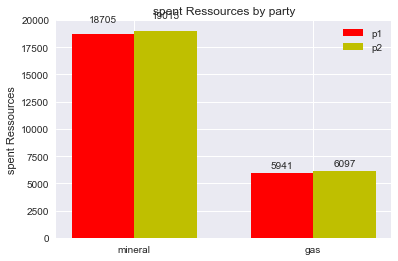

In [20]:
"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

N = 2
men_means = (non_sparse_dataset.p1_spent_minerals.sum()/34578, non_sparse_dataset.p1_spent_gas.sum()/34578)

ind = np.arange(N)  # the x locations for the groups

width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r')

women_means = (non_sparse_dataset.p2_spent_minerals.sum()/34578, non_sparse_dataset.p2_spent_gas.sum()/34578)
rects2 = ax.bar(ind + width, women_means, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('spent Ressources')
ax.set_title('spent Ressources by party')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('mineral', 'gas'))

ax.legend((rects1[0], rects2[0]), ('p1', 'p2'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

# Extract the target variable
La cible à prédire est le vainqueur du match indiqué dans la variable _p1_win_game.

In [21]:
# tableau des victoires/defaites du joueur p1
# y = resultats
y = non_sparse_dataset._p1_win_game.as_matrix()
y

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [22]:
# X = les données 
# les donnees sont encapsulees dans un objet pandas.
# iloc[colonnes, lignes]
# puis convert DataFrame to numpy array
X = non_sparse_dataset.iloc[:,1:].as_matrix()


In [23]:
# Les caracteristiques : on retire les colonnes p1_win_game et game_length
#.columns pour garder uniquement les titres des colonnes
features = non_sparse_dataset.iloc[:,2:].columns
features

Index([u'p1_APM', u'p1_APM_wo_select', u'p1_assigned_hotkeys',
       u'p1_building_types', u'p1_collected_gas', u'p1_collected_minerals',
       u'p1_max_distance_from_opponent', u'p1_mean_distance_from_opponent',
       u'p1_min_distance_from_opponent', u'p1_nb_scooting',
       u'p1_selected_hotkeys', u'p1_spent_gas', u'p1_spent_minerals',
       u'p1_timing_1st_scooting', u'p1_unit_types', u'p2_APM',
       u'p2_APM_wo_select', u'p2_assigned_hotkeys', u'p2_building_types',
       u'p2_collected_gas', u'p2_collected_minerals',
       u'p2_max_distance_from_opponent', u'p2_mean_distance_from_opponent',
       u'p2_min_distance_from_opponent', u'p2_nb_scooting',
       u'p2_selected_hotkeys', u'p2_spent_gas', u'p2_spent_minerals',
       u'p2_timing_1st_scooting', u'p2_unit_types'],
      dtype='object')

# Split the train and test dataset

# sklearn : module de machine learning pour python 
# train_test_split : pour découper le jeu de données en train/test
from sklearn.cross_validation import train_test_split
# 30% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [24]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.sort()
X_train

array([[  5.00000000e+00,   5.49022505e+00,   6.00000000e+00, ...,
          7.57252513e+03,   1.05000000e+04,   1.59500000e+04],
       [  2.08287992e+00,   2.80746946e+00,   6.00000000e+00, ...,
          1.15250000e+04,   1.40611330e+04,   2.14500000e+04],
       [  2.15334724e+00,   3.88783161e+00,   5.00000000e+00, ...,
          1.90250000e+04,   3.05000000e+04,   4.04939658e+04],
       ..., 
       [  4.21069732e+00,   5.00000000e+00,   5.50757205e+00, ...,
          6.70228307e+03,   7.85000000e+03,   9.10000000e+03],
       [ -1.43529241e+03,   6.20081168e-01,   4.00000000e+00, ...,
          3.48425239e+03,   6.05240186e+03,   6.90000000e+03],
       [  1.38837790e+00,   1.59405394e+00,   5.00000000e+00, ...,
          2.58250000e+04,   2.92125463e+04,   3.41750000e+04]])

# Standardizing

In [25]:
from sklearn.preprocessing import StandardScaler
# Certains algo sont moins performants si le jeu de données n'est pas centré sur zero,
# avec une distribution de type gaussienne, ou avec des bornes [0:1] 
stdsc = StandardScaler()
# calcule la moyenne des données puis lui applique un facteur d'échelle
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Cross-validation protocol

In [26]:
#KFold : pour diviser les données 
from sklearn.cross_validation import KFold

#** arguments sous la forme de dico
#X : les donnees
#y : les resultats
#clf_class : un type de classifier : par exemple l'estimateur SVC

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    #KFold : len(y)?
    # nombre de portions:3, et regroupement des données identiques avant decoupage
    kf = KFold(len(y),n_folds=3,shuffle=True)
    # copie la DataFrame des resultats
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # un classifier est un exemple d'estimator, un objet python qui implemente les 
        # methodes .fit(X,y) et predict(T) 
        # Initialize a classifier with keyword arguments
        clf = clf_class(**kwargs)
        # le classifier apprend du modele grace au jeu d'entrainement
        clf.fit(X_train,y_train)
        # puis predit de nouvelles valeurs via le jeu de test
        y_pred[test_index] = clf.predict(X_test)
    return y_pred
# la fonction renvoie les resultats prédits pour le jeu de test (prochaine etape : evaluer l'erreur de la prediction)

In [27]:
# Import de toute une serie d'estimateurs ?
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

# une methode pour evaluer la precision des modeles
def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)



# Preparing a sample experiment

In [28]:
# on prend 1/10 du jeu d'entrainement, arrondi à l'unite
small_train_index = round(len(X_train)/10)
small_train_index

2417.0

In [29]:
# Les nouveaux X et y pour ce jeu restreint 
# les algorithmes de sklearn prennent des np.array en entrée
y = y_train[:int(small_train_index)]
X = X_train_std[:int(small_train_index),:]
print("X length = %d and y length = %d" % (len(X), len(y)))

X length = 2417 and y length = 2417


In [30]:
# Test des differents modeles
# Plus grande precision : Logistic Regression LR
print "Logistic Regression:"
print "%.3f" % accuracy(y, run_cv(X,y,LR))
print "Gradient Boosting Classifier"
print "%.3f" % accuracy(y, run_cv(X,y,GBC))
print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))

Logistic Regression:
0.510
Gradient Boosting Classifier
0.494
Support vector machines:
0.494
Random forest:
0.499
K-nearest-neighbors:
0.502


# Feature selection

In [31]:
from sklearn import svm

# Plusieurs facon d'evaluer la qualite d'un modele 
# l'une est d'utiliser des outils de cross-validation tels que les fonctions de score 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
f =[]
s =[]
# Le noyau : linear, RBF, polynomial ... depend si les points de données sont séparables linéairement
# Ici, a priori oui ...
# Je ne vois pas trop pourquoi il utilise le modele SVC plutot que le modele LR (meilleure note)
# A tester ...
svc = svm.SVC(kernel='linear')
svc.C = 0.01

for features_nb in range(X.shape[1],1, -1):
    f.append(features_nb)
    X_new = SelectKBest(k=features_nb).fit_transform(X, y)
    # Evaluation de la qualite du modele
    this_scores = cross_val_score(svc, X_new, y, n_jobs=8)
    s.append(np.mean(this_scores))

In [32]:
print("The best number of features = %d" % f[s.index(max(s))])

The best number of features = 3


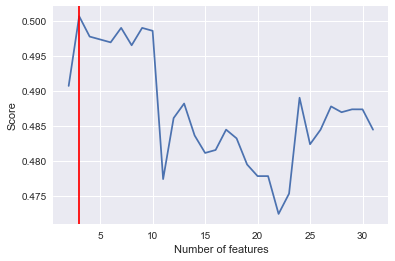

In [33]:
#inverted list of number of features
plt.plot(f,s)
plt.xlabel("Number of features")
plt.ylabel("Score")
# Ajoute une ligne verticale au max
plt.axvline(f[s.index(max(s))],color='r')
plt.show()

In [34]:
# Filtre les caracteristiques les plus importantes (182/240, pourquoi ?)
# j'utilise le jeu de données normal (plus le tout petit)
sk = SelectKBest(k='all')
X_new_train = sk.fit_transform(X_train, y_train)
X_new_test = sk.transform(X_test)

In [35]:
# cree un masque avec les carateristiques qui ont passé le test 
ix = sk.get_support(indices=True)
ix

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)

In [36]:
list(features[ix-1])

['p2_unit_types',
 'p1_APM',
 'p1_APM_wo_select',
 'p1_assigned_hotkeys',
 'p1_building_types',
 'p1_collected_gas',
 'p1_collected_minerals',
 'p1_max_distance_from_opponent',
 'p1_mean_distance_from_opponent',
 'p1_min_distance_from_opponent',
 'p1_nb_scooting',
 'p1_selected_hotkeys',
 'p1_spent_gas',
 'p1_spent_minerals',
 'p1_timing_1st_scooting',
 'p1_unit_types',
 'p2_APM',
 'p2_APM_wo_select',
 'p2_assigned_hotkeys',
 'p2_building_types',
 'p2_collected_gas',
 'p2_collected_minerals',
 'p2_max_distance_from_opponent',
 'p2_mean_distance_from_opponent',
 'p2_min_distance_from_opponent',
 'p2_nb_scooting',
 'p2_selected_hotkeys',
 'p2_spent_gas',
 'p2_spent_minerals',
 'p2_timing_1st_scooting',
 'p2_unit_types']

# Feature importance

Feature ranking:
1. p1_APM (0.034826)
2. p1_APM_wo_select (0.033584)
3. p1_assigned_hotkeys (0.031953)
4. p1_building_types (0.030422)
5. p1_collected_gas (0.030177)
6. p1_collected_minerals (0.024413)
7. p1_max_distance_from_opponent (0.019344)
8. p1_mean_distance_from_opponent (0.018717)
9. p1_min_distance_from_opponent (0.017187)
10. p1_nb_scooting (0.016918)


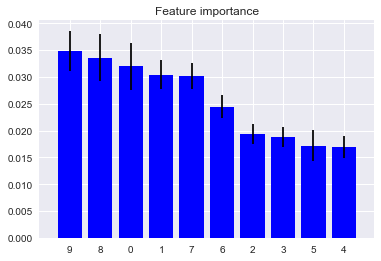

In [37]:
#RF : RandomForestClassifier
forest = RF()
forest_fit = forest.fit(X_new_train, y_train)
forest_prediction = forest_fit.predict(X_new_test)

# renvoie un array avec les importances relatives des 10 premieres caracteristiques
importances = forest_fit.feature_importances_[:10]

# numpy.std : Returns the standard deviation, a measure of the spread of a distribution
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# Renvoie un tableau des indices dans l'ordre où ils seraient après un tri
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f+1, features[f], importances[indices[f]]))
    
#plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices], yerr=std[indices], color="b", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1,10])
plt.show()

### APM = actions per minute


# Optimizing

In [54]:
svc = svm.SVC(kernel='linear')
C_s = np.logspace(-3, -1, 10)
# retourne 50 nombres entre 10**-3 et 10**-1

scores = list()
scores_std = list()

# ces nombres sont utilisés comme parametre C de svc

# Globalement : le modele SVM est très dépendant du choix de ses deux paramètres, C et \gamma
#  TODO   une optimisation globale peut être réalisée grace à la méthode sklearn.model_selection.GridSearchCV
#
# Mega long, besoin de limiter au jeu de données restreint ?
for C in C_s:
    svc.C = C
    # fonctions de score enfonction de C
    # Standardisation 
    this_scores = cross_val_score(svc, X_new_train, y_train, n_jobs=4)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    


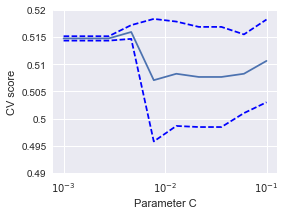

In [55]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')

# Choix graphique d'un parametre svc.C
plt.show()

In [56]:
max(scores)

0.51593966400970726

## Feature engeneering

In [38]:
non_sparse_dataset.iloc[:,2:].head()

,p1_APM,p1_APM_wo_select,p1_assigned_hotkeys,p1_building_types,p1_collected_gas,p1_collected_minerals,p1_max_distance_from_opponent,p1_mean_distance_from_opponent,p1_min_distance_from_opponent,p1_nb_scooting,p1_selected_hotkeys,p1_spent_gas,p1_spent_minerals,p1_timing_1st_scooting,p1_unit_types,p2_APM,p2_APM_wo_select,p2_assigned_hotkeys,p2_building_types,p2_collected_gas,p2_collected_minerals,p2_max_distance_from_opponent,p2_mean_distance_from_opponent,p2_min_distance_from_opponent,p2_nb_scooting,p2_selected_hotkeys,p2_spent_gas,p2_spent_minerals,p2_timing_1st_scooting,p2_unit_types
0,253.755960,117.501591,11,7,2165.078261,6168.725404,87.352990,54.396229,4.082069,101,254,1150,8350,4.150304,5,306.270928,141.696509,32,6,2263.485578,2989.957948,78.431581,40.823145,1.326082,126,650,125,5625,45.788680,5
1,409.814560,184.973045,49,12,7105.031731,22587.206226,147.601756,100.841505,5.770096,25,674,3475,18425,68.886024,6,362.382878,171.733135,40,14,6513.180336,15631.134319,150.694422,102.180624,2.195000,34,847,5775,26000,117.381424,7
2,119.058515,50.509673,2,10,2533.724502,4606.670526,134.754321,103.870012,3.303471,7,4,1075,5275,161.771632,4,274.390387,64.355954,3,5,3018.371741,1855.957303,132.819855,92.206773,0.701632,124,2,1200,7275,475.345144,3
3,283.797292,108.285775,9,5,1706.586960,4753.958950,146.460952,93.168556,6.834298,24,7,2125,7425,117.110752,6,146.886867,69.288787,8,4,0.000000,6775.502105,148.651391,128.721351,109.445248,0,83,0,10100,104.163608,2
4,110.532544,56.996046,7,10,4188.468752,2189.298894,181.691168,104.511326,2.836126,124,38,2125,11550,160.237824,6,142.069858,28.033273,7,8,5462.485766,6029.324813,181.614012,148.276518,1.357620,62,24,3350,12550,631.703336,4


In [39]:
# dataset est un pd.dataFrame
df = non_sparse_dataset.iloc[:,2:]
df.head()

,p1_APM,p1_APM_wo_select,p1_assigned_hotkeys,p1_building_types,p1_collected_gas,p1_collected_minerals,p1_max_distance_from_opponent,p1_mean_distance_from_opponent,p1_min_distance_from_opponent,p1_nb_scooting,p1_selected_hotkeys,p1_spent_gas,p1_spent_minerals,p1_timing_1st_scooting,p1_unit_types,p2_APM,p2_APM_wo_select,p2_assigned_hotkeys,p2_building_types,p2_collected_gas,p2_collected_minerals,p2_max_distance_from_opponent,p2_mean_distance_from_opponent,p2_min_distance_from_opponent,p2_nb_scooting,p2_selected_hotkeys,p2_spent_gas,p2_spent_minerals,p2_timing_1st_scooting,p2_unit_types
0,253.755960,117.501591,11,7,2165.078261,6168.725404,87.352990,54.396229,4.082069,101,254,1150,8350,4.150304,5,306.270928,141.696509,32,6,2263.485578,2989.957948,78.431581,40.823145,1.326082,126,650,125,5625,45.788680,5
1,409.814560,184.973045,49,12,7105.031731,22587.206226,147.601756,100.841505,5.770096,25,674,3475,18425,68.886024,6,362.382878,171.733135,40,14,6513.180336,15631.134319,150.694422,102.180624,2.195000,34,847,5775,26000,117.381424,7
2,119.058515,50.509673,2,10,2533.724502,4606.670526,134.754321,103.870012,3.303471,7,4,1075,5275,161.771632,4,274.390387,64.355954,3,5,3018.371741,1855.957303,132.819855,92.206773,0.701632,124,2,1200,7275,475.345144,3
3,283.797292,108.285775,9,5,1706.586960,4753.958950,146.460952,93.168556,6.834298,24,7,2125,7425,117.110752,6,146.886867,69.288787,8,4,0.000000,6775.502105,148.651391,128.721351,109.445248,0,83,0,10100,104.163608,2
4,110.532544,56.996046,7,10,4188.468752,2189.298894,181.691168,104.511326,2.836126,124,38,2125,11550,160.237824,6,142.069858,28.033273,7,8,5462.485766,6029.324813,181.614012,148.276518,1.357620,62,24,3350,12550,631.703336,4


In [40]:
# Cette partie pour ne conserver que les colonnes communes à p1 et p2

colnames = df.columns.values
# colnames est un numpy.ndarray
# de 238 colonnes
colnames
# creer une sous_liste avec les colonnes contenant p1
p1_colnames = [name for name in colnames if "p1" in name]
p1_colnames = [name[2:]+'$' for name in p1_colnames ]
p2_colnames = [name for name in colnames if "p2" in name]
p2_colnames = [name[2:]+'$' for name in p2_colnames ]
print str(len(p1_colnames)) + " " + str(len(p2_colnames))
colnames = [name for name in p1_colnames if name in p2_colnames ]
len(colnames)
colnames

15 15


['_APM$',
 '_APM_wo_select$',
 '_assigned_hotkeys$',
 '_building_types$',
 '_collected_gas$',
 '_collected_minerals$',
 '_max_distance_from_opponent$',
 '_mean_distance_from_opponent$',
 '_min_distance_from_opponent$',
 '_nb_scooting$',
 '_selected_hotkeys$',
 '_spent_gas$',
 '_spent_minerals$',
 '_timing_1st_scooting$',
 '_unit_types$']

In [41]:
colnames.sort()
colnames
# A présent, c'est une liste triée

['_APM$',
 '_APM_wo_select$',
 '_assigned_hotkeys$',
 '_building_types$',
 '_collected_gas$',
 '_collected_minerals$',
 '_max_distance_from_opponent$',
 '_mean_distance_from_opponent$',
 '_min_distance_from_opponent$',
 '_nb_scooting$',
 '_selected_hotkeys$',
 '_spent_gas$',
 '_spent_minerals$',
 '_timing_1st_scooting$',
 '_unit_types$']

In [42]:
# nouvelle DataFrame : p1-p2 pour chaque colonne
select_df = pd.DataFrame()
for name in colnames:
    # Fait : retirer les colonnes qui n'existent que pour p1 et pas pour p2
    # filtre par une regular expression
    # A priori, le $ doit eviter d'inclure les colonnes pi_APM_wo_select 
    filt_df = df.filter(regex=name)
    # Pour toutes les lignes sauf la première, select_df fait la difference entre les donnees p1 et p2
    select_df[name[:-1]] = filt_df.iloc[:,0]-filt_df.iloc[:,1]
    # matrice a partir de toutes les lignes et de la premiere colonne
    # idem seconde colonne
select_df


,_APM,_APM_wo_select,_assigned_hotkeys,_building_types,_collected_gas,_collected_minerals,_max_distance_from_opponent,_mean_distance_from_opponent,_min_distance_from_opponent,_nb_scooting,_selected_hotkeys,_spent_gas,_spent_minerals,_timing_1st_scooting,_unit_types
0,-52.514968,-24.194918,-21,1,-98.407317,3178.767457,8.921409,13.573083,2.755987,-25,-396,1025,2725,-41.638376,0
1,47.431682,13.239911,9,-2,591.851395,6956.071907,-3.092666,-1.339119,3.575096,-9,-173,-2300,-7575,-48.495400,-1
2,-155.331871,-13.846281,-1,5,-484.647238,2750.713222,1.934465,11.663239,2.601839,-117,2,-125,-2000,-313.573512,1
3,136.910425,38.996989,1,1,1706.586960,-2021.543155,-2.190440,-35.552794,-102.610951,24,-76,2125,-2675,12.947144,4
4,-31.537314,28.962773,0,2,-1274.017014,-3840.025920,0.077156,-43.765192,1.478506,62,14,-1225,-1000,-471.465512,2
5,46.429228,42.495301,39,2,7413.507587,10215.125190,-5.617830,-7.490532,-3.920287,54,157,5625,-8700,139.576528,-1
6,76.171064,47.020254,-34,-3,5601.593130,-26343.339615,0.710945,12.839797,9.401957,-25,-982,-18975,-39925,-68.525128,-2
7,-20.428540,22.033535,21,-4,-8327.440618,1385.443654,-4.665032,6.300937,8.070410,-76,76,-8200,-12100,45.924016,-2
8,50.810624,54.707203,3,0,-1183.820082,1556.630161,-2.638155,0.559489,2.124138,-57,7,125,-200,153.786808,1
9,-35.183754,-36.080611,1,1,827.958581,-8204.754022,3.421183,-23.633545,-2.364031,103,25,2725,1875,0.360896,4


In [62]:
# donnees reorganisées sous forme de matrice
# centrée et normalisée
stdsc = StandardScaler()
scaled_mat = stdsc.fit_transform(select_df)
scaled_mat

array([[-0.72446933, -0.50371648, -1.06983042, ...,  0.41217096,
        -0.52709997,  0.70812363],
       [-0.01999674, -0.89178368, -0.46362284, ...,  0.90138823,
        -0.61228793,  0.70812363],
       [-2.48991974, -0.40763857, -0.16051905, ..., -0.65944781,
         0.75184027,  0.70812363],
       ..., 
       [ 1.39857157,  1.10389205,  1.05189611, ..., -0.03045418,
        -0.43686799,  0.70812363],
       [-2.43843038, -0.39512985, -0.31207094, ...,  0.08602612,
        -2.31940974,  0.70812363],
       [ 0.87557883,  1.2138314 , -0.61517473, ...,  0.36557884,
        -1.14807534, -0.01163554]])

In [63]:
# objet DataFrame à partir de cette matrice
scaled_df = pd.DataFrame(scaled_mat, columns=select_df.columns.values)

In [64]:
# fonction de stat pour dataFrame
scaled_df.describe()

,_APM,_APM_wo_select,_assigned_hotkeys,_building_types,_collected_gas,_collected_minerals,_max_distance_from_opponent,_mean_distance_from_opponent,_min_distance_from_opponent,_nb_scooting,_selected_hotkeys,_spent_gas,_spent_minerals,_timing_1st_scooting,_unit_types
count,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04,3.457900e+04
mean,9.888912e-18,-1.483337e-18,-2.955950e-16,8.157197e-16,7.641432e-19,1.414307e-17,-1.490400e-17,1.190001e-17,-3.818950e-17,1.035286e-17,1.804004e-18,-9.496566e-17,-2.485873e-17,-2.908881e-18,-4.321464e-16
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-6.350831e+00,-1.365516e+01,-1.183001e+01,-3.720524e+00,-6.934543e+00,-1.307403e+01,-7.799049e+00,-5.526028e+00,-5.662216e+00,-1.181767e+01,-8.818785e+00,-7.659035e+00,-1.295977e+01,-3.635900e+00,-3.610431e+00
25%,-6.366437e-01,-6.223842e-01,-6.151747e-01,-4.569724e-01,-5.856429e-01,-5.967591e-01,-2.996785e-01,-5.713459e-01,-1.999375e-01,-4.754745e-01,-2.763604e-01,-6.264500e-01,-5.895596e-01,-6.386289e-01,-7.313947e-01
50%,1.746339e-03,1.305451e-03,-8.967153e-03,9.249199e-03,1.006319e-03,4.046920e-03,-7.965688e-03,-2.331449e-03,-5.543186e-03,-2.093996e-03,-6.030499e-03,1.939971e-02,-7.158120e-03,-4.763290e-03,-1.163554e-02
75%,6.316716e-01,6.184141e-01,5.972404e-01,4.754708e-01,5.861036e-01,5.887665e-01,2.847069e-01,5.620374e-01,1.965629e-01,4.712865e-01,2.681612e-01,5.934883e-01,5.985394e-01,6.352673e-01,7.081236e-01
max,5.555242e+00,5.394928e+00,2.302692e+01,3.739022e+00,8.633907e+00,1.155020e+01,6.897266e+00,5.643067e+00,5.373463e+00,1.135904e+01,9.111811e+00,8.917773e+00,1.364433e+01,3.611241e+00,2.867401e+00


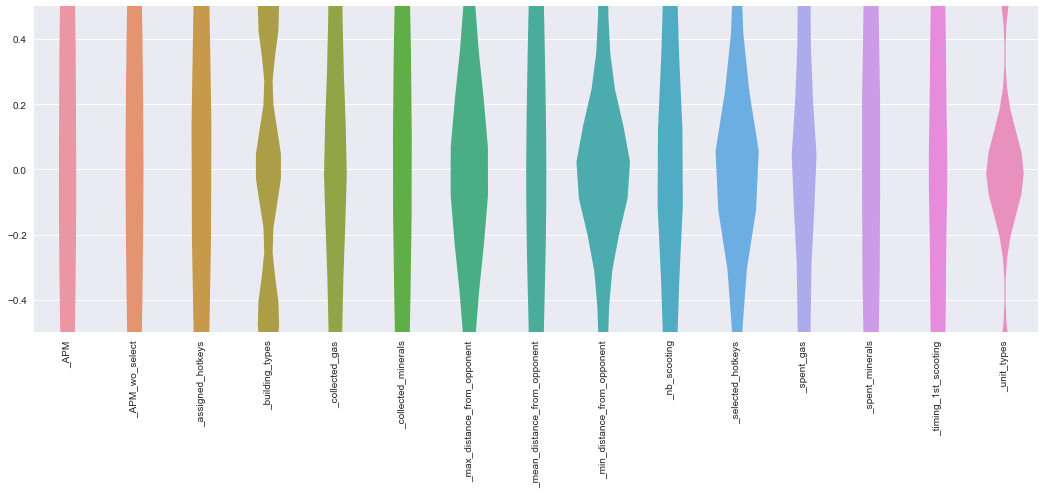

In [65]:
# visualisation via seaborn
plt.figure(figsize=(18, 6))
g = sns.violinplot(data=scaled_df, cut=0, inner=None, linewidth=0)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylim(-.5,.5)
plt.show()

In [66]:
# mmesure de dispersion Q3 - Q1
inter_quantile_range = scaled_df.quantile(q=.75) - scaled_df.quantile(q=.25)

In [67]:
inter_quantile_range.sort_values(inplace=True, ascending=False)


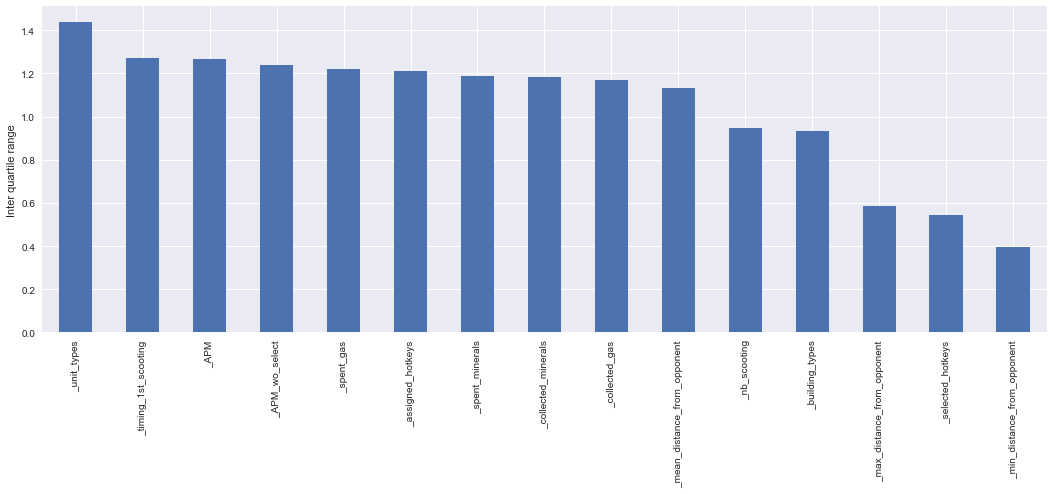

In [68]:
plt.figure(figsize=(18, 6))
inter_quantile_range.plot.bar()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylabel("Inter quartile range")
plt.show()

In [69]:
# En ne selectionnant que les colonnes avec une forte dispersion
selected_cols = inter_quantile_range.ix[inter_quantile_range > 0.05].index.values
inter_quantile_range.ix[inter_quantile_range > 0.05]
selected_cols

array(['_unit_types', '_timing_1st_scooting', '_APM', '_APM_wo_select',
       '_spent_gas', '_assigned_hotkeys', '_spent_minerals',
       '_collected_minerals', '_collected_gas',
       '_mean_distance_from_opponent', '_nb_scooting', '_building_types',
       '_max_distance_from_opponent', '_selected_hotkeys',
       '_min_distance_from_opponent'], dtype=object)

In [70]:
# on garde les selected_cols et on supprime le reste. Le second argument contient le sous tableau a supprimer
# ici Hatchery est le nombre de couveuses.
# Retiré est exclusif aux zerk et n'est donc pas directement une différence sur un critere rencontré par les 
# deux joueurs ?
selected_cols_wo_APM = np.delete(selected_cols,[1])

In [71]:
scaled_df[selected_cols_wo_APM]

,_unit_types,_APM,_APM_wo_select,_spent_gas,_assigned_hotkeys,_spent_minerals,_collected_minerals,_collected_gas,_mean_distance_from_opponent,_nb_scooting,_building_types,_max_distance_from_opponent,_selected_hotkeys,_min_distance_from_opponent
0,0.708124,-0.724469,-0.503716,0.449966,-1.069830,0.412171,-0.384864,-0.308873,0.169148,0.149388,0.009249,0.709191,-0.778402,0.083984
1,0.708124,-0.019997,-0.891784,-0.913494,-0.463623,0.901388,1.282558,-0.839651,0.017430,-0.134641,-1.389416,-0.121301,-0.596894,0.115220
2,0.708124,-2.489920,-0.407639,-0.411167,-0.160519,-0.659448,0.440781,0.141202,0.392934,0.130453,0.941692,0.123567,-0.006030,-2.669915
3,1.427883,1.528193,1.406478,2.100471,0.445689,-0.822520,-0.658583,2.075489,-0.903005,0.300870,0.475471,-0.158791,-0.230018,-3.502686
4,1.427883,-0.230482,0.650536,0.019400,0.142585,-0.356599,0.850887,-1.395002,-4.187769,1.834622,-0.923194,-0.003569,0.082792,-4.820529
5,-0.011636,-0.224024,-0.260554,-0.482928,1.051896,-0.403191,-0.074763,-0.001063,-0.477572,-0.342928,-0.923194,-0.535820,0.071207,0.499400
6,-0.011636,-0.057171,1.067004,-0.411167,0.142585,-1.008889,0.325478,-0.158331,0.977938,0.073647,-1.389416,0.608434,-2.137775,-0.059420
7,1.427883,-1.469638,0.394942,0.378205,-0.160519,0.575243,0.626196,-0.134016,0.053853,-0.153576,0.009249,-0.566017,0.005555,0.737988
8,-0.011636,0.634791,1.407011,0.162922,0.445689,-0.053750,0.730466,-2.061061,0.265822,-1.554782,0.475471,-0.189438,0.005555,0.346032
9,-0.011636,0.110293,-0.499652,0.737010,-0.008967,-1.544698,-0.925904,1.121537,-0.704410,0.774250,0.941692,0.025233,0.275885,-0.087134


In [72]:
# mise en forme pour train_test
X = scaled_df[selected_cols_wo_APM].as_matrix()
y = non_sparse_dataset._p1_win_game.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [73]:
len(X_train)

24205

In [74]:
print "Logistic Regression:"
print "%.3f" % accuracy(y, run_cv(X,y,LR))
print "Gradient Boosting Classifier"
print "%.3f" % accuracy(y, run_cv(X,y,GBC))
print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))

Logistic Regression:
0.567
Gradient Boosting Classifier
0.564
Support vector machines:
0.562
Random forest:
0.530
K-nearest-neighbors:
0.521


In [75]:
svc = svm.SVC(kernel='linear')
C_s = np.logspace(-3, -1, 50)

scores = list()
scores_std = list()

for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, n_jobs=4)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

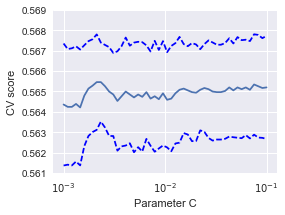

In [76]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')

plt.show()

In [77]:
max(scores)

0.5654588999244986